# Imports

In [1]:
import torch
from torchvision import transforms
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torch.nn as nn

import timm

from PIL import Image
import os
from contextlib import redirect_stdout
import ssl

import time

import matplotlib.pyplot as plt

ssl._create_default_https_context = ssl._create_unverified_context

# Constants

In [2]:
dataset_path = '/kaggle/input/version-2/Stage 3/Stage 3'

# Dataset & Preprocessing

In [3]:
class ResizeWithPadding:
    def __init__(self, size):
        self.size = size

    def __call__(self, img):
        w, h = img.size
        if h > w:
            new_h = self.size
            new_w = int(w * (self.size / h))
        else:
            new_w = self.size
            new_h = int(h * (self.size / w))
        
        resized_img = img.resize((new_w, new_h), Image.LANCZOS)

        padded_img = Image.new("RGB", (self.size, self.size), color=(0, 0, 0))
        padded_img.paste(resized_img, ((self.size - new_w) // 2, (self.size - new_h) // 2))
        
        return padded_img

transform = transforms.Compose([
    ResizeWithPadding(256),
    transforms.ToTensor(),
])

if os.path.exists(dataset_path + '.DS_Store'):
        os.remove(dataset_path + '.DS_Store')

dataset = datasets.ImageFolder(root=dataset_path, transform=transform)

In [4]:
total_size = len(dataset)

train_size = int(0.8 * total_size)
val_size = int(0.1 * total_size)
test_size = total_size - train_size - val_size

train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, val_size, test_size])

# Loading & Modifying ResNet-152 Model

In [5]:
resnet_model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet50', pretrained=True)

with redirect_stdout(None):
    resnet_model.eval()

num_features = resnet_model.fc.in_features
num_classes = 2

new_fc_layers = [
    torch.nn.Linear(num_features, 512),
    torch.nn.ReLU(),
    torch.nn.Dropout(0.5),
    torch.nn.Linear(512, 256),
    torch.nn.ReLU(),
    torch.nn.Dropout(0.5),
    torch.nn.Linear(256, num_classes)
]
resnet_model.fc = torch.nn.Sequential(*new_fc_layers)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


# Loading & Modifying InceptionV4 Model

In [6]:
inception_model = timm.create_model('inception_v3', pretrained=True)

num_features = inception_model.fc.in_features
num_classes = 2

new_fc_layers = nn.Sequential(
    nn.Linear(num_features, 512),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(512, 256),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(256, num_classes)
)

inception_model.fc = new_fc_layers

# Hyperparameters

In [7]:
num_epochs = 10
batch_size = 32
criterion = torch.nn.CrossEntropyLoss()
resnet_optimizer = torch.optim.Adam(resnet_model.parameters(), lr=0.00001)
inception_optimizer = torch.optim.Adam(inception_model.parameters(), lr=0.00001)
resnet_model = resnet_model.to('cuda')
inception_model = inception_model.to('cuda')

# Training

In [8]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [9]:
def train(mod, name, opt):
    best_val_loss = float('inf')
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    sensitivities = []
    specificities = []

    for epoch in range(num_epochs):
        start_time = time.time()
        mod.train()
        train_loss = 0
        correct_train = 0
        total_train = 0
        true_positives = 0
        true_negatives = 0
        false_positives = 0
        false_negatives = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to('cuda'), labels.to('cuda')
            opt.zero_grad()

            outputs = mod(inputs)
            loss = criterion(outputs, labels)

            loss.backward()
            opt.step()

            train_loss += loss.item()
            _, predicted_train = torch.max(outputs, 1)
            total_train += labels.size(0)
            correct_train += (predicted_train == labels).sum().item()

            true_positives += ((predicted_train == 1) & (labels == 1)).sum().item()
            true_negatives += ((predicted_train == 0) & (labels == 0)).sum().item()
            false_positives += ((predicted_train == 1) & (labels == 0)).sum().item()
            false_negatives += ((predicted_train == 0) & (labels == 1)).sum().item()

        train_loss /= len(train_loader)
        train_accuracy = 100 * correct_train / total_train

        sensitivity = true_positives / (true_positives + false_negatives)
        specificity = true_negatives / (true_negatives + false_positives)

        mod.eval()
        val_loss = 0
        correct_val = 0
        total_val = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to('cuda'), labels.to('cuda')
                outputs = mod(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted_val = torch.max(outputs, 1)
                total_val += labels.size(0)
                correct_val += (predicted_val == labels).sum().item()

        val_loss /= len(val_loader)
        val_accuracy = 100 * correct_val / total_val

        flag = False
        if val_loss < best_val_loss:
            flag = True
            best_val_loss = val_loss
            torch.save(mod.state_dict(), f'best_{name}_model.pth')

        end_time = time.time()
        epoch_time = end_time - start_time

        if flag:
            print(f'Epoch [{epoch+1}/{num_epochs}]: {epoch_time:.2f}s | Saved Model\nTrain Loss: {train_loss:.4f} | Train Accuracy: {train_accuracy:.2f}%\nValidation Loss: {val_loss:.4f} | Validation Accuracy: {val_accuracy:.2f}%')
        else:
            print(f'Epoch [{epoch+1}/{num_epochs}]: {epoch_time:.2f}s\nTrain Loss: {train_loss:.4f} | Train Accuracy: {train_accuracy:.2f}%\nValidation Loss: {val_loss:.4f} | Validation Accuracy: {val_accuracy:.2f}%')
        print('===================================================================================================')

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accuracies.append(train_accuracy)
        val_accuracies.append(val_accuracy)
        sensitivities.append(sensitivity)
        specificities.append(specificity)
        
    return train_losses, val_losses, train_accuracies, val_accuracies, sensitivities, specificities

def plot_graphs(train_losses, val_losses, train_accuracies, val_accuracies, sensitivities, specificities):
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()

    plt.figure(figsize=(10, 5))
    plt.plot(train_accuracies, label='Training Accuracy')
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.show()

    plt.figure(figsize=(10, 5))
    plt.plot(sensitivities, label='Sensitivity')
    plt.plot(specificities, label='Specificity')
    plt.xlabel('Epoch')
    plt.ylabel('Value')
    plt.title('Sensitivity and Specificity')
    plt.legend()
    plt.show()

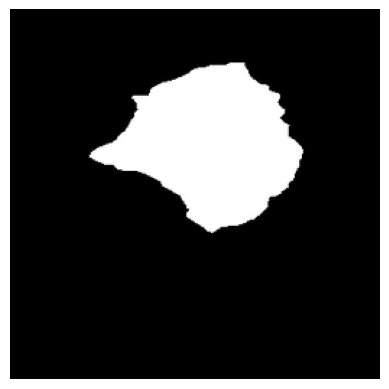

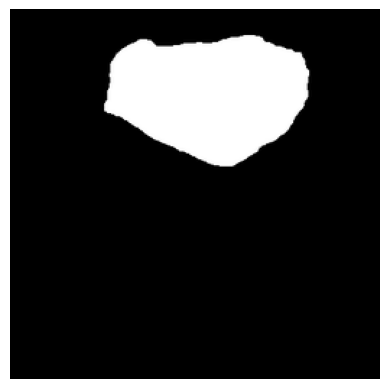

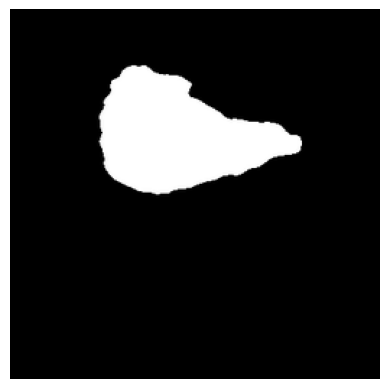

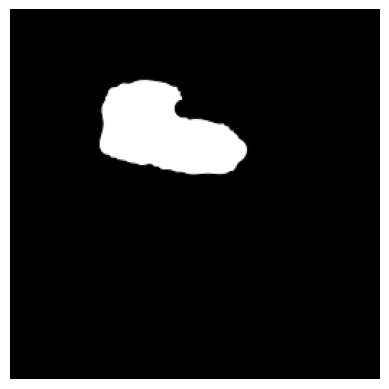

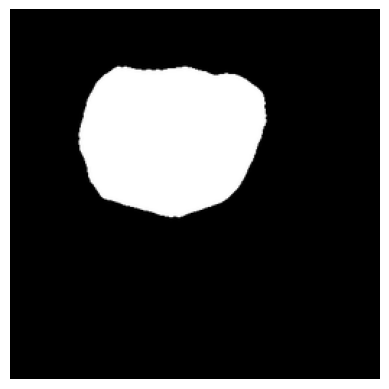

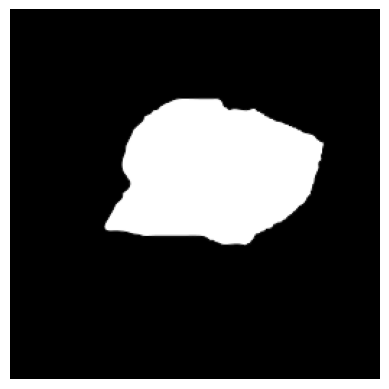

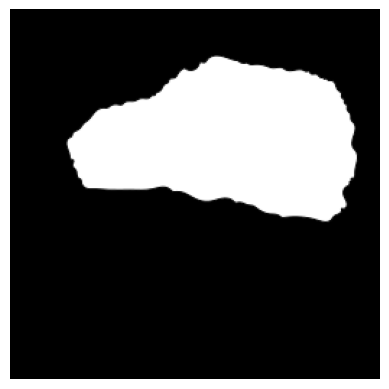

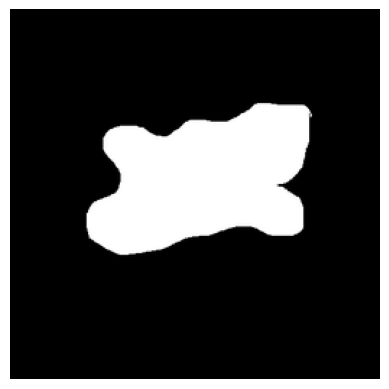

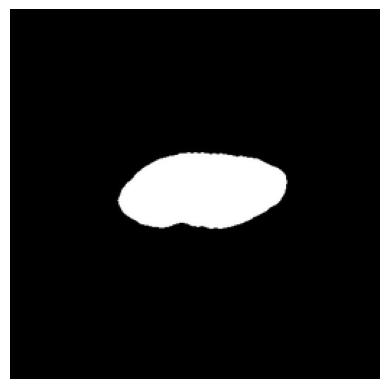

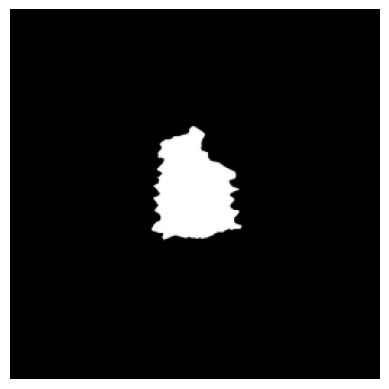

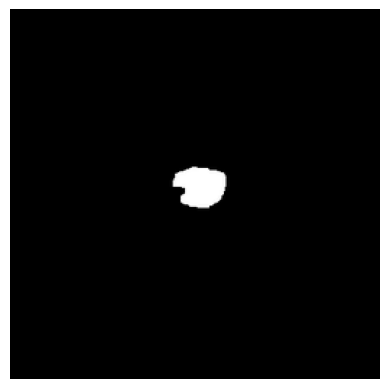

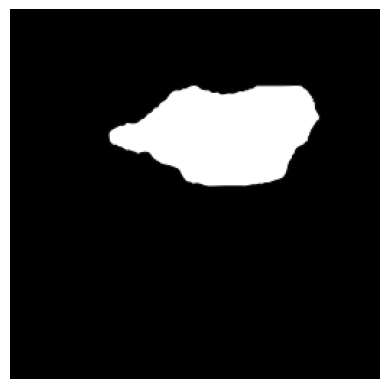

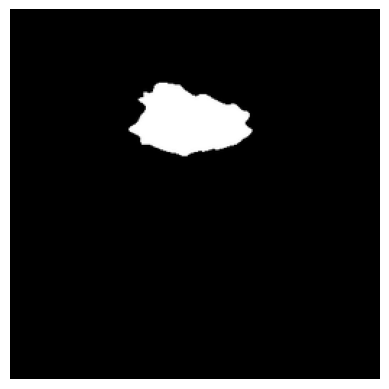

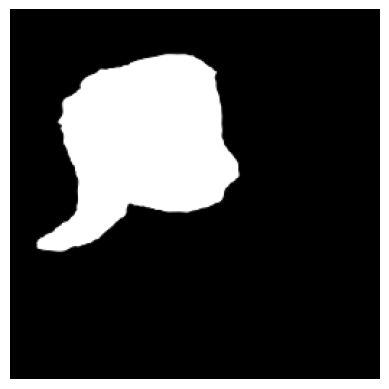

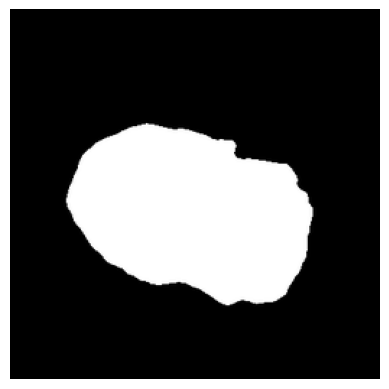

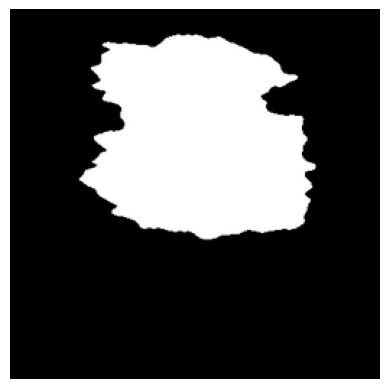

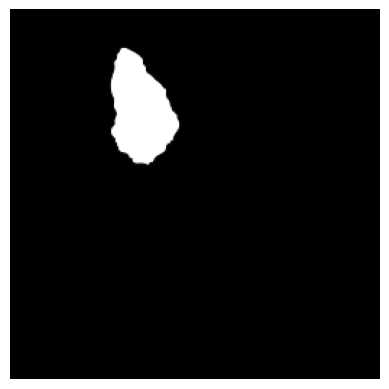

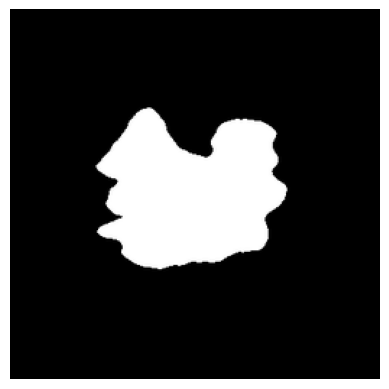

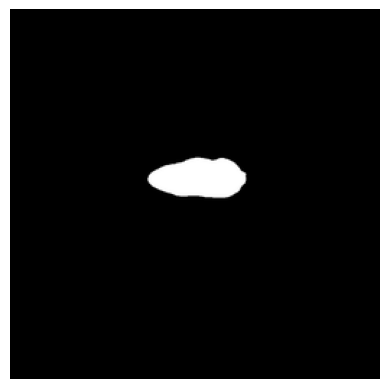

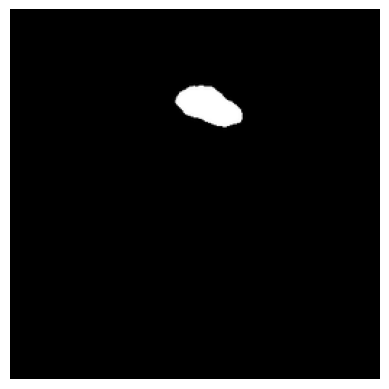

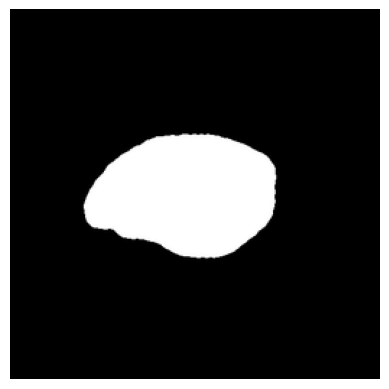

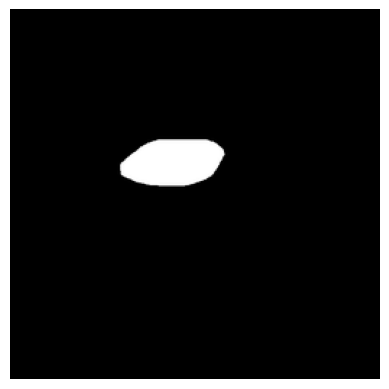

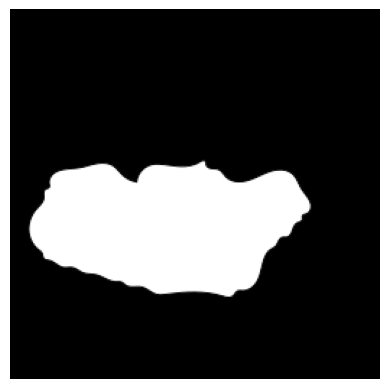

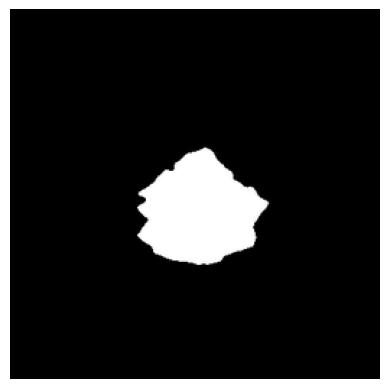

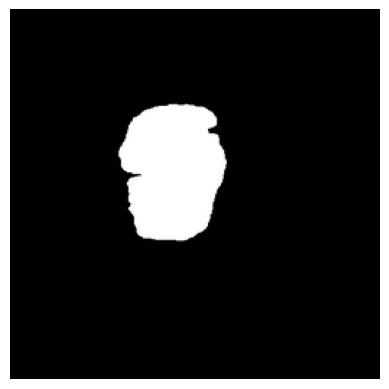

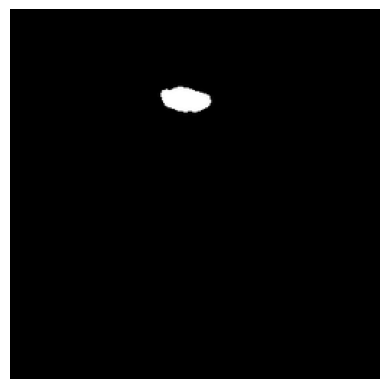

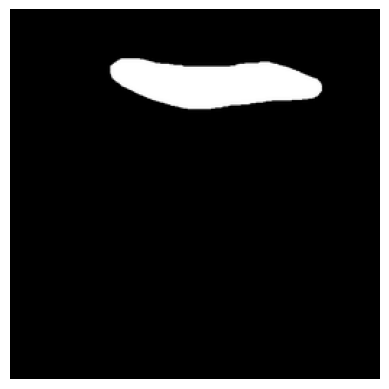

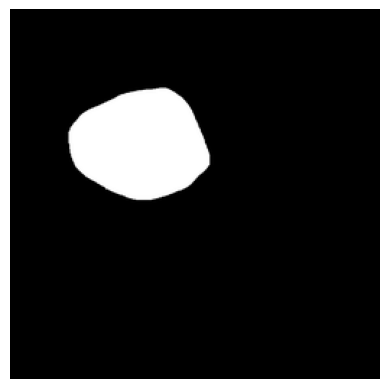

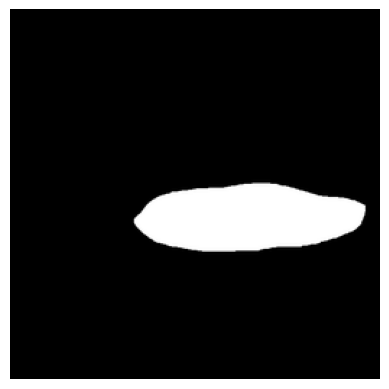

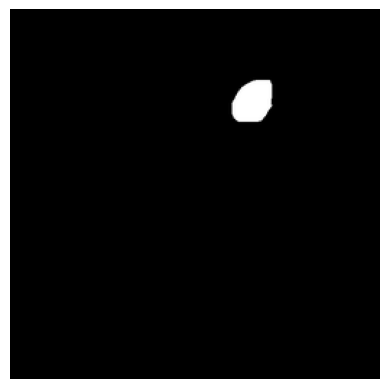

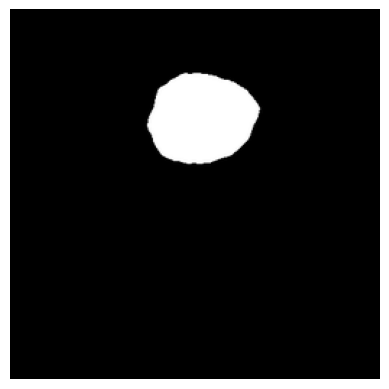

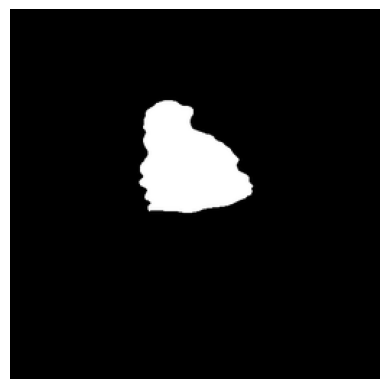

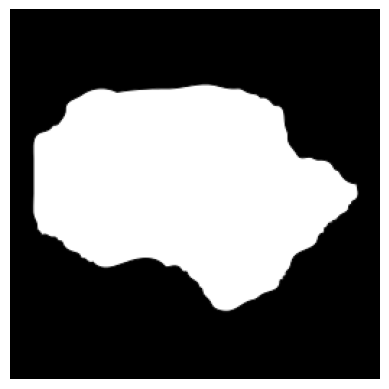

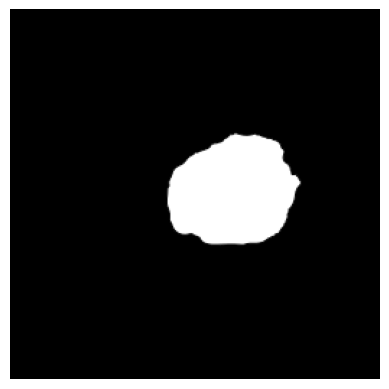

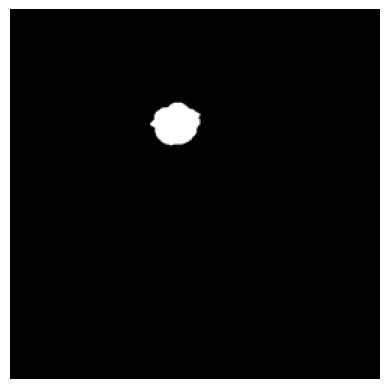

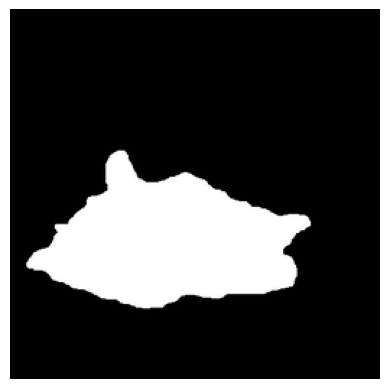

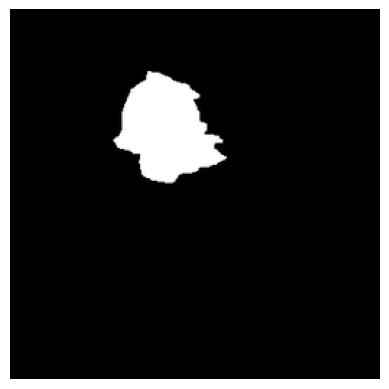

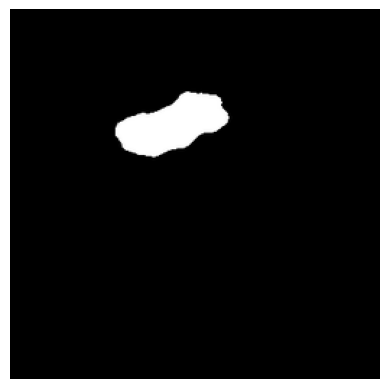

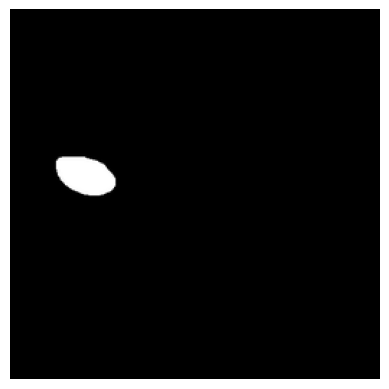

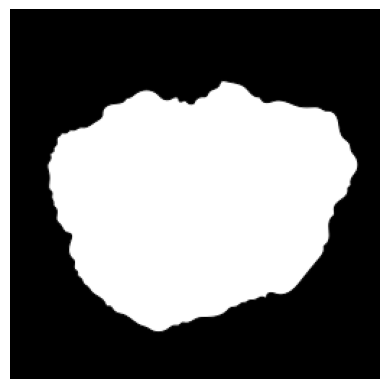

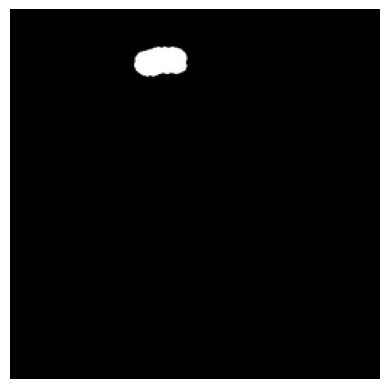

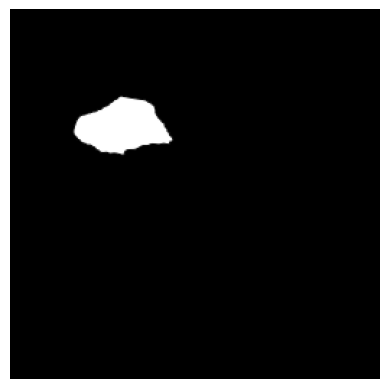

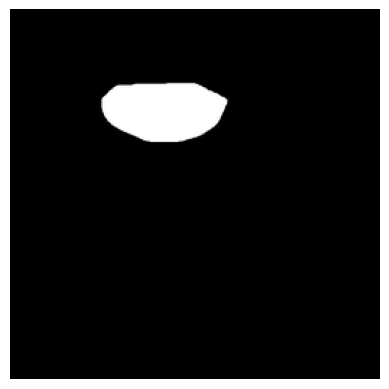

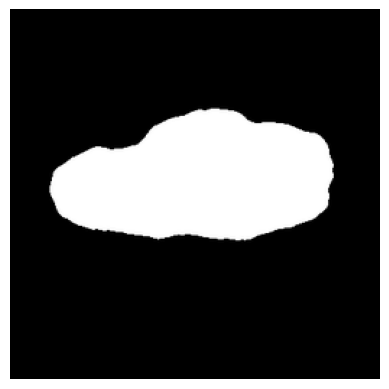

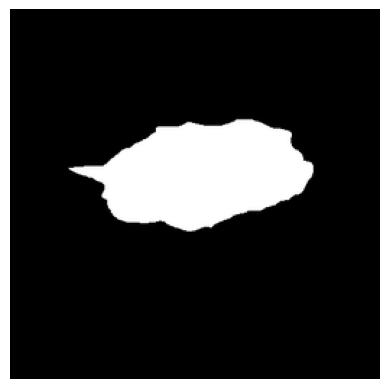

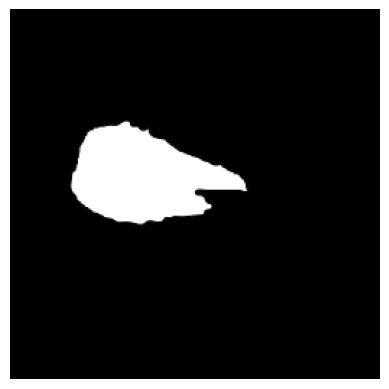

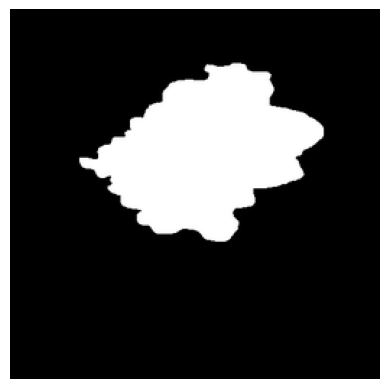

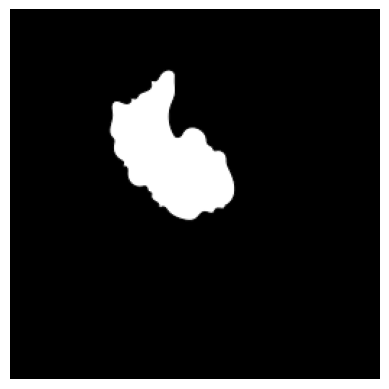

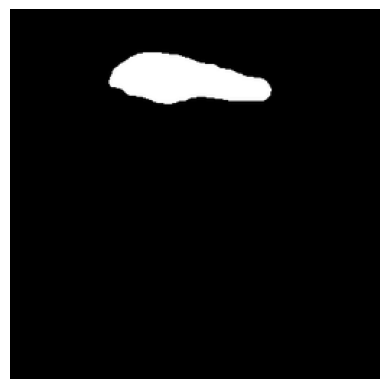

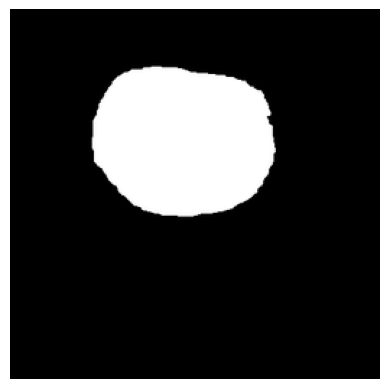

In [10]:
count = 0
for images, labels in train_loader:
    for image in images:
        plt.imshow(image.permute(1, 2, 0))
        plt.axis('off')
        plt.show()
        count += 1
        if count == 50:
            break
    if count == 50:
        break

In [11]:
inception_train_losses, inception_val_losses, inception_train_accuracies, inception_val_accuracies, inception_sensitivities, inception_specificities = train(inception_model, 'inception', inception_optimizer)

Epoch [1/10]: 34.43s | Saved Model
Train Loss: 0.6245 | Train Accuracy: 61.44%
Validation Loss: 0.5043 | Validation Accuracy: 68.01%
Epoch [2/10]: 33.91s | Saved Model
Train Loss: 0.4903 | Train Accuracy: 71.86%
Validation Loss: 0.4260 | Validation Accuracy: 82.13%
Epoch [3/10]: 33.82s | Saved Model
Train Loss: 0.4073 | Train Accuracy: 84.19%
Validation Loss: 0.3925 | Validation Accuracy: 81.56%
Epoch [4/10]: 33.63s | Saved Model
Train Loss: 0.3170 | Train Accuracy: 88.32%
Validation Loss: 0.3876 | Validation Accuracy: 83.00%
Epoch [5/10]: 33.58s
Train Loss: 0.2336 | Train Accuracy: 92.09%
Validation Loss: 0.4085 | Validation Accuracy: 82.42%
Epoch [6/10]: 33.56s
Train Loss: 0.1515 | Train Accuracy: 95.76%
Validation Loss: 0.4904 | Validation Accuracy: 82.71%
Epoch [7/10]: 33.62s
Train Loss: 0.1103 | Train Accuracy: 97.16%
Validation Loss: 0.4898 | Validation Accuracy: 82.13%
Epoch [8/10]: 33.63s
Train Loss: 0.0882 | Train Accuracy: 97.34%
Validation Loss: 0.5541 | Validation Accuracy:

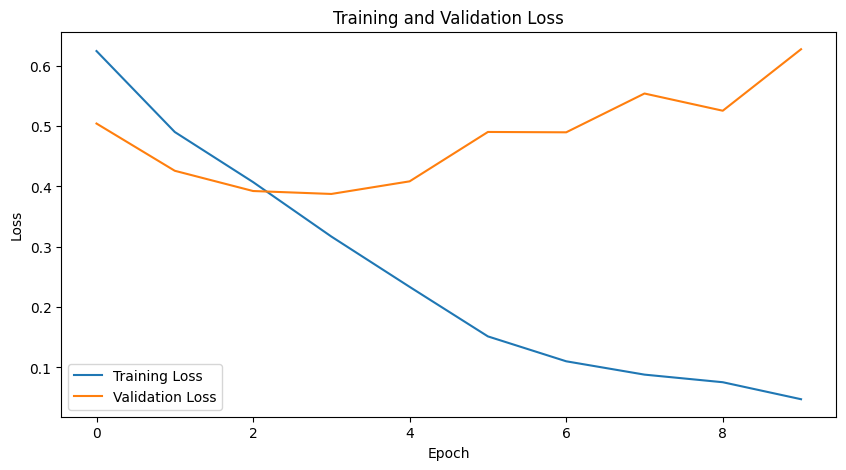

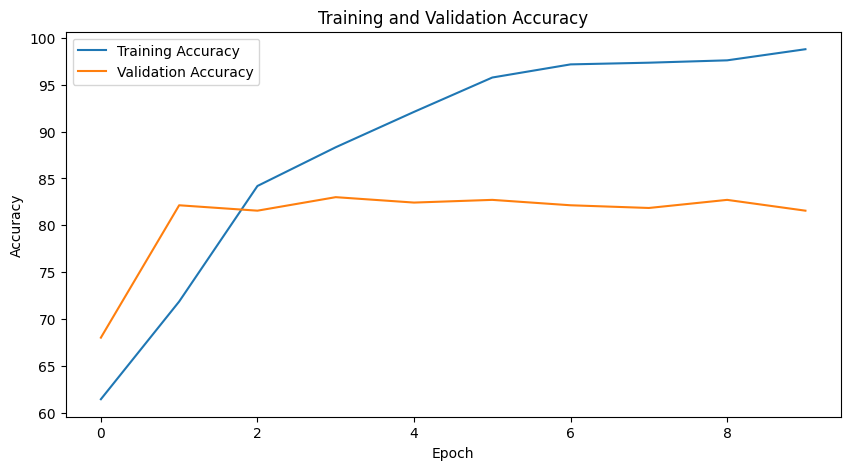

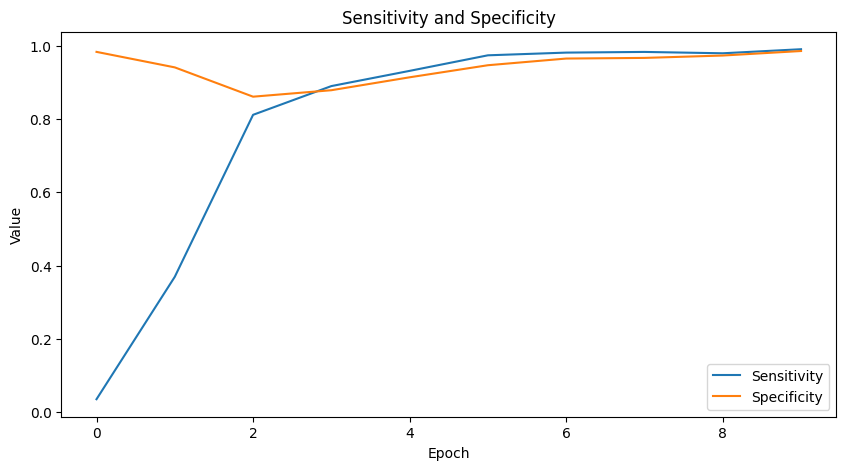

In [12]:
plot_graphs(inception_train_losses, inception_val_losses, inception_train_accuracies, inception_val_accuracies, inception_sensitivities, inception_specificities)

In [13]:
resnet_train_losses, resnet_val_losses, resnet_train_accuracies, resnet_val_accuracies, resnet_sensitivities, resnet_specificities = train(resnet_model, 'resnet', resnet_optimizer)

Epoch [1/10]: 34.34s | Saved Model
Train Loss: 0.6177 | Train Accuracy: 65.76%
Validation Loss: 0.4990 | Validation Accuracy: 77.81%
Epoch [2/10]: 34.20s | Saved Model
Train Loss: 0.4558 | Train Accuracy: 79.91%
Validation Loss: 0.3979 | Validation Accuracy: 82.42%
Epoch [3/10]: 34.30s | Saved Model
Train Loss: 0.3476 | Train Accuracy: 86.27%
Validation Loss: 0.3902 | Validation Accuracy: 81.84%
Epoch [4/10]: 33.93s
Train Loss: 0.2326 | Train Accuracy: 92.38%
Validation Loss: 0.4552 | Validation Accuracy: 81.56%
Epoch [5/10]: 33.82s
Train Loss: 0.1348 | Train Accuracy: 96.69%
Validation Loss: 0.4830 | Validation Accuracy: 80.98%
Epoch [6/10]: 33.74s
Train Loss: 0.0833 | Train Accuracy: 98.20%
Validation Loss: 0.5593 | Validation Accuracy: 82.71%
Epoch [7/10]: 33.88s
Train Loss: 0.0486 | Train Accuracy: 99.07%
Validation Loss: 0.5739 | Validation Accuracy: 82.13%
Epoch [8/10]: 33.85s
Train Loss: 0.0268 | Train Accuracy: 99.53%
Validation Loss: 0.6865 | Validation Accuracy: 80.69%
Epoch 

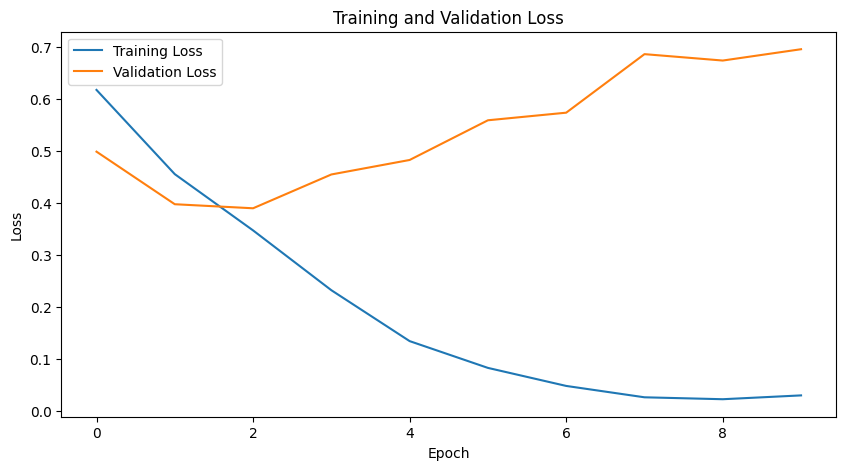

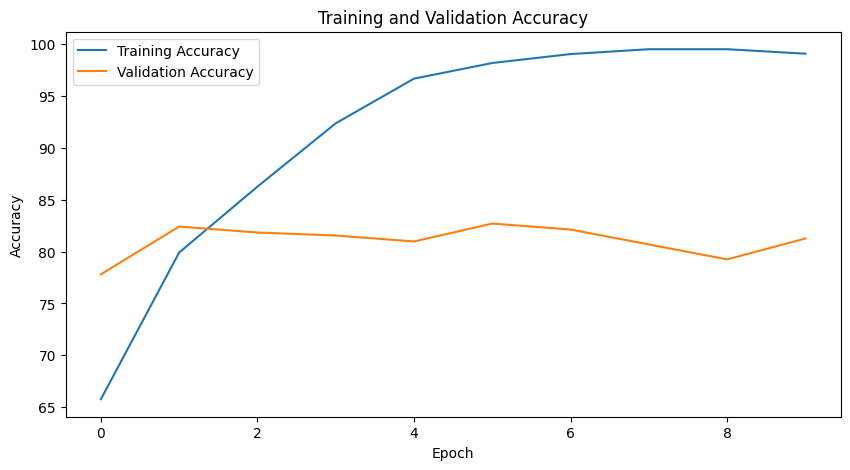

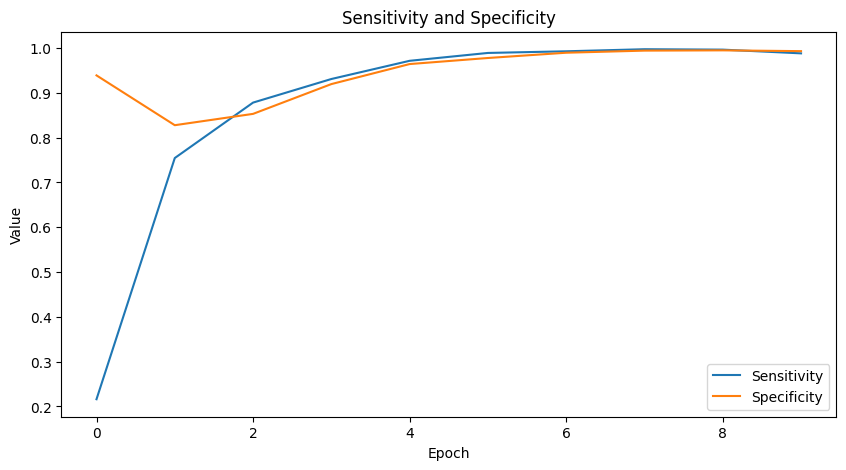

In [14]:
plot_graphs(resnet_train_losses, resnet_val_losses, resnet_train_accuracies, resnet_val_accuracies, resnet_sensitivities, resnet_specificities)

In [15]:
def test(model, name):
    model.load_state_dict(torch.load(f'best_{name}_model.pth'))

    model.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to('cuda'), labels.to('cuda')
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    test_loss /= len(test_loader)
    test_accuracy = 100 * correct / total

    print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%')

In [16]:
test(inception_model, 'inception')

Test Loss: 0.3989, Test Accuracy: 82.52%


In [17]:
test(resnet_model, 'resnet')

Test Loss: 0.4148, Test Accuracy: 82.23%


In [18]:
def test_ensemble(models, names):
    total_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to('cuda'), labels.to('cuda')
            ensemble_outputs = torch.zeros(inputs.size(0), num_classes).to('cuda')

            for model, name in zip(models, names):
                model.eval()
                outputs = model(inputs)
                ensemble_outputs += outputs

            ensemble_outputs /= len(models)

            loss = criterion(ensemble_outputs, labels)
            total_loss += loss.item()
            _, predicted = torch.max(ensemble_outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    test_loss = total_loss / len(test_loader)
    test_accuracy = 100 * correct / total

    print(f'Ensemble Test Loss: {test_loss:.4f}, Ensemble Test Accuracy: {test_accuracy:.2f}%')
    

In [19]:
test_ensemble([inception_model, resnet_model], ['inception', 'resnet'])

Ensemble Test Loss: 0.3867, Ensemble Test Accuracy: 83.09%
